In [127]:
!pip install pandas numpy scikit-learn torch

In [128]:
# check torch gpu
import torch

device = None

print("<!> Selecting GPU as main device <!>")
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    device = torch.device("cuda")
    print("<!> Using: " + torch.cuda.get_device_name(0) + "<!>")
else:
    print("<!> No GPU available <!>")
    exit(0)

<!> Selecting GPU as main device <!>
<!> Using: NVIDIA GeForce GTX 1050<!>


In [129]:
import pandas as pd

print("<!> Loading train dataframe <!>")
train_df = pd.read_csv('/root/test/train_transactions.csv')

<!> Loading train dataframe <!>


<!> Training <!>
Epoch 1, Loss: 0.0253
Epoch 2, Loss: 0.0051
Epoch 3, Loss: 0.0040
Epoch 4, Loss: 0.0041
Epoch 5, Loss: 0.0044
Epoch 6, Loss: 0.0039
Epoch 7, Loss: 0.0037
Epoch 8, Loss: 0.0041
Epoch 9, Loss: 0.0041
Epoch 10, Loss: 0.0054
Epoch 11, Loss: 0.0047
Epoch 12, Loss: 0.0040
Epoch 13, Loss: 0.0037
Epoch 14, Loss: 0.0035
Epoch 15, Loss: 0.0035
Epoch 16, Loss: 0.0038
Epoch 17, Loss: 0.0034
Epoch 18, Loss: 0.0034
Epoch 19, Loss: 0.0033
Epoch 20, Loss: 0.0040
Epoch 21, Loss: 0.0035
Epoch 22, Loss: 0.0023
Epoch 23, Loss: 0.0019
Epoch 24, Loss: 0.0019
Epoch 25, Loss: 0.0016
Epoch 26, Loss: 0.0014
Epoch 27, Loss: 0.0016
Epoch 28, Loss: 0.0016
Epoch 29, Loss: 0.0014
Epoch 30, Loss: 0.0013
Epoch 31, Loss: 0.0013
Epoch 32, Loss: 0.0014
Epoch 33, Loss: 0.0013
Epoch 34, Loss: 0.0013
Epoch 35, Loss: 0.0015
Epoch 36, Loss: 0.0014
Epoch 37, Loss: 0.0013
Epoch 38, Loss: 0.0014
Epoch 39, Loss: 0.0015
Epoch 40, Loss: 0.0012
Epoch 41, Loss: 0.0011
Epoch 42, Loss: 0.0012
Epoch 43, Loss: 0.0011
Epo

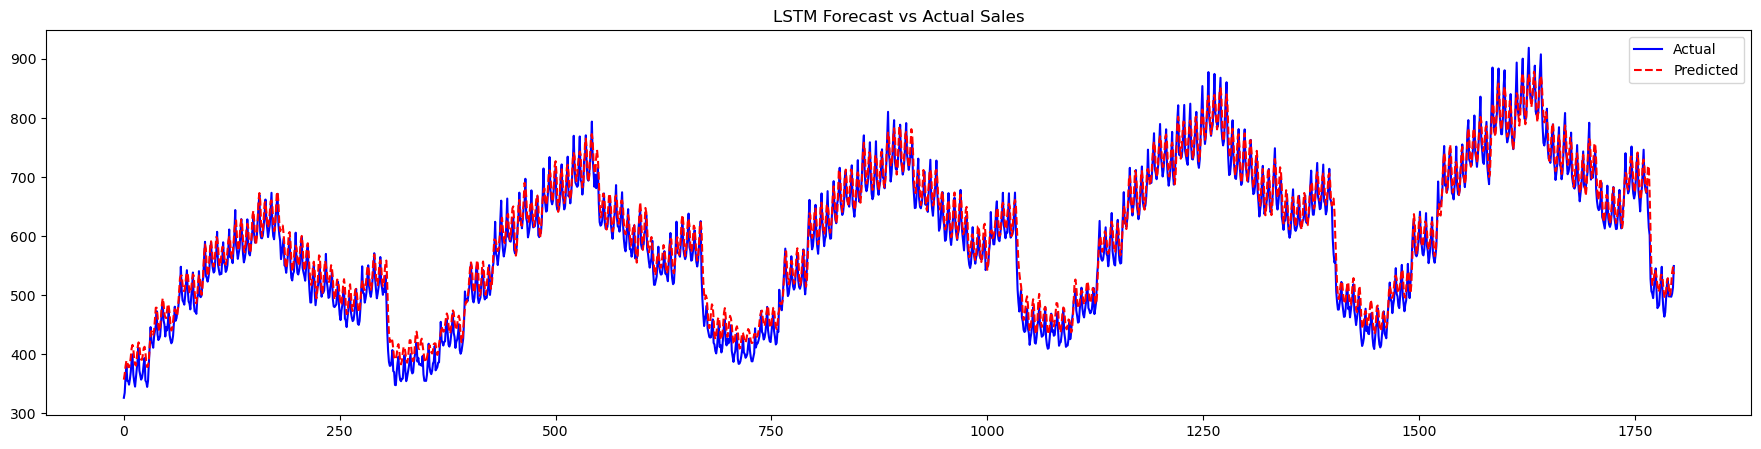

        ds    y_actual  yhat_forecast      error  error_percentage
0        0  326.531036     357.223206 -30.692169         -9.399465
1        1  335.071747     366.734497 -31.662750         -9.449544
2        2  362.650208     380.412872 -17.762665         -4.898016
3        3  381.655151     389.436066  -7.780914         -2.038729
4        4  355.058594     388.443451 -33.384857         -9.402634
...    ...         ...            ...        ...               ...
1791  1791  498.660797     502.810852  -4.150055         -0.832240
1792  1792  497.562561     518.861511 -21.298950         -4.280658
1793  1793  502.793793     538.477661 -35.683868         -7.097117
1794  1794  513.355652     547.329346 -33.973694         -6.617964
1795  1795  549.548950     535.634216  13.914734          2.532028

[1796 rows x 5 columns]
Mean Error Percentage: -2.84%


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from math import sqrt

# Function to create sequences
def create_sequences(data, seq_length):
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        targets.append(data[i+seq_length])
    return np.array(sequences), np.array(targets)

# Function for Exponential Smoothing
def exponential_smoothing(series, alpha):
    result = [series[0]]  # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return np.array(result)

# Load and preprocess training dataset
train_df = pd.read_csv('/root/test/train_transactions.csv')
train_series = train_df[str(2)].values.reshape(-1, 1)

# Apply Exponential Smoothing
alpha = 0.3  # Smoothing factor
smoothed_series = exponential_smoothing(train_series.flatten(), alpha).reshape(-1, 1)

# Normalize data
scaler = MinMaxScaler()
smoothed_series = scaler.fit_transform(smoothed_series)

# Generate sequences
SEQ_LENGTH = 30
X_train, y_train = create_sequences(smoothed_series, SEQ_LENGTH)

# Convert to PyTorch tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train, y_train = torch.tensor(X_train, dtype=torch.float32).to(device), torch.tensor(y_train, dtype=torch.float32).to(device)

# Create Dataset class
class DemandDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = DemandDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define LSTM Model
class LSTMPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate=0.2):
        super(LSTMPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                            batch_first=True, dropout=dropout_rate)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_step_output = lstm_out[:, -1, :]
        x = self.fc1(last_step_output)
        x = self.relu(x)
        return self.fc2(x)

# Model setup
INPUT_SIZE = 1
HIDDEN_SIZE = 128
NUM_LAYERS = 3
OUTPUT_SIZE = 1
DROPOUT_RATE = 0.2

model = LSTMPredictor(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE, DROPOUT_RATE).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
EPOCHS = 50

# Training function
def train_model():
    model.train()
    for epoch in range(EPOCHS):
        total_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

print("<!> Training <!>")
train_model()
print("<!> Done <!>")

# Save model
torch.save(model.state_dict(), "/root/test/lstm_trained_data.pth")

# Load test dataset
test_df = pd.read_csv('/root/test/test_transactions.csv')
test_series = test_df[str(2)].values.reshape(-1, 1)

# Apply Exponential Smoothing to test data
smoothed_test_series = exponential_smoothing(test_series.flatten(), alpha).reshape(-1, 1)

# Normalize test data using the same scaler
smoothed_test_series = scaler.transform(smoothed_test_series)

# Create test sequences
X_test, y_test = create_sequences(smoothed_test_series, SEQ_LENGTH)

# Convert test data to PyTorch tensors
X_test, y_test = torch.tensor(X_test, dtype=torch.float32).to(device), torch.tensor(y_test, dtype=torch.float32).to(device)

# Function for evaluation
def evaluate_forecast(y_true, y_pred):
    mape = mean_absolute_percentage_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = sqrt(mse)
    smape = 100 * np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))
    r2 = r2_score(y_true, y_pred)

    print("\n=== Evaluation for LSTM Model ===")
    print(f"  - Mean Absolute Percentage Error (MAPE): {mape:.2f}")
    print(f"  - Symmetric MAPE (SMAPE): {smape:.2f}")
    print(f"  - Mean Squared Error (MSE): {mse:.2f}")
    print(f"  - Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"  - R² Score: {r2:.2f}")

# Make predictions
model.eval()
with torch.no_grad():
    y_pred = model(X_test).cpu().numpy()

y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.cpu().numpy())

# Evaluate the model
evaluate_forecast(y_test, y_pred)

# Plot results
plt.figure(figsize=(22, 5))
plt.plot(y_test, label="Actual", color="blue")
plt.plot(y_pred, label="Predicted", color="red", linestyle="dashed")
plt.legend()
plt.title("LSTM Forecast vs Actual Sales")
plt.show()

# Compare forecasted sales to actual sales
comparison = pd.DataFrame({"ds": range(len(y_test)), "y_actual": y_test.flatten(), "yhat_forecast": y_pred.flatten()})
comparison['error'] = comparison['y_actual'] - comparison['yhat_forecast']
comparison['error_percentage'] = (comparison['error'] / comparison['y_actual']) * 100
print(comparison)

# Calculate mean error percentage
mean_error_percentage = comparison['error_percentage'].mean()
print(f"Mean Error Percentage: {mean_error_percentage:.2f}%")